In [64]:
import pickle
import numpy as np
import sys
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io.votable import parse
from astropy.table import Table

from scipy.optimize import curve_fit

In [19]:
d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57639/whole_field/'
sefluxname = 'best'
secat = pickle.load( open(d+'whole_field_secat_'+sefluxname+'.p', "rb" ) )
g = secat.jy>1.e-10
secat = cat_utils.Catalog(secat.ra[g],secat.dec[g],secat.jy[g])

In [20]:
# apass cat
apasscatdat = np.genfromtxt('/home/abrahamn/xcor_data/ir_catalogs/apass_6degcat.csv',skip_header=2,delimiter=',')
has_iprime_mag = np.logical_not(np.isnan(apasscatdat[:,23]))
apass_cat = cat_utils.Catalog(apasscatdat[has_iprime_mag,2],apasscatdat[has_iprime_mag,3],3631.*10.**(-apasscatdat[has_iprime_mag,23]/2.5))

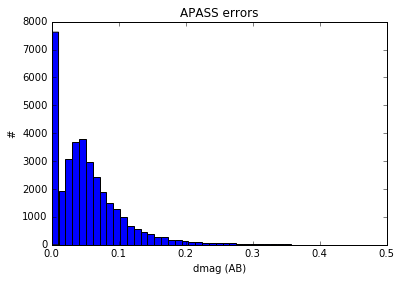

In [21]:
h = plt.hist(apasscatdat[has_iprime_mag,24],np.linspace(0,.5))
plt.xlabel('dmag (AB)')
plt.ylabel('#')
plt.title('APASS errors')

In [22]:
# dophot cat
dophot_cat = cat_utils.IRCatalog('/home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph')
dophot_cat.ra = dophot_cat.ra_all
dophot_cat.dec = dophot_cat.dec_all
dophot_cat.jy = dophot_cat.jy_all

loading /home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph


In [23]:
# plt.plot(dophot_cat.ra_all,dophot_cat.dec_all,'.')

In [24]:
# to get early skymapper data, do a cone search through an australian proxy
# http://skymapper.anu.edu.au.prx.teleport.to/edr_cone/query?RA=1&DEC=-29&SR=.35&VERB=2

# need to edit the xml file and change datatypes "character(18)" and "character(3)" to "char"
catdir = '/home/abrahamn/xcor_data/ir_catalogs/'
skymappercatraw = parse(catdir + 'view-source_skymapper.anu.edu.au.prx.teleport.to_edr_cone_query_RA=1&DEC=-29&SR=.35&VERB=2.xml').get_first_table().array

In [25]:
skymappercatraw.dtype

dtype((numpy.record, [('r_cntr', '<f8'), ('smss_j', 'S1'), ('raj2000', '<f8'), ('dej2000', '<f8'), ('e_raj2000', '<i4'), ('e_dej2000', '<i4'), ('mean_epoch', '<f8'), ('rms_epoch', '<f4'), ('glon', '<f4'), ('glat', '<f4'), ('flags', '<i2'), ('class_star', '<f4'), ('nobs', 'S'), ('object_id', '<i8'), ('radius_petro', '<f4'), ('a', '<f4'), ('e_a', '<f4'), ('b', '<f4'), ('e_b', '<f4'), ('pa', '<f4'), ('e_pa', '<f4'), ('u_psf', '<f4'), ('e_u_psf', '<f4'), ('u_petro', '<f4'), ('e_u_petro', '<f4'), ('v_psf', '<f4'), ('e_v_psf', '<f4'), ('v_petro', '<f4'), ('e_v_petro', '<f4'), ('g_psf', '<f4'), ('e_g_psf', '<f4'), ('g_petro', '<f4'), ('e_g_petro', '<f4'), ('r_psf', '<f4'), ('e_r_psf', '<f4'), ('r_petro', '<f4'), ('e_r_petro', '<f4'), ('i_psf', '<f4'), ('e_i_psf', '<f4'), ('i_petro', '<f4'), ('e_i_petro', '<f4'), ('z_psf', '<f4'), ('e_z_psf', '<f4'), ('z_petro', '<f4'), ('e_z_petro', '<f4'), ('ebmv_sfd', '<f4'), ('prox', '<f4'), ('prox_id', '<i8'), ('density', '<i4'), ('twomass_key1', '<i8'), 

In [26]:
# http://skymapper.anu.edu.au/table-browser/
ra = skymappercatraw['raj2000']
dec = skymappercatraw['dej2000']
flags = skymappercatraw['flags']
ab_mag_psf = skymappercatraw['i_psf'] # mag measured by psf fitting
d_ab_mag_psf = skymappercatraw['e_i_psf'] # mag measured by psf fitting
ab_mag_petro = skymappercatraw['i_petro'] # mag measured in an azimuthally averaged radius, see http://www.sdss.org/dr12/algorithms/magnitudes/#mag_petro

jy_psf = 3631.*10.**(-ab_mag_psf/2.5)
jy_petro = 3631.*10.**(-ab_mag_petro/2.5)

skymapper_cat = cat_utils.Catalog(ra,dec,jy_psf)

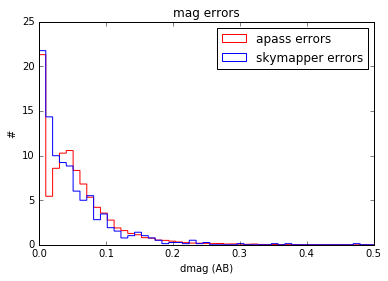

In [27]:
h = plt.hist(apasscatdat[has_iprime_mag,24],np.linspace(0,.5),histtype='step',label='apass errors',normed=True,color='red')
h = plt.hist(d_ab_mag_psf,np.linspace(0,.5),histtype='step',label='skymapper errors',normed=True,color='blue')
plt.xlabel('dmag (AB)')
plt.ylabel('#')
plt.legend()
plt.title('mag errors')

In [28]:
# secat = secat.bound_with_cat(skymapper_cat)
# dophot_cat = dophot_cat.bound_with_cat(skymapper_cat)
# apass_cat = apass_cat.bound_with_cat(skymapper_cat)

In [29]:
# plt.figure(figsize=(20,15))
# plt.scatter(ra,dec,25000*skymapper_cat.jy,edgecolor='none',facecolor='red')

# plt.scatter(secat_bounded.ra,secat_bounded.dec,25000*secat_bounded.jy,facecolor='none')
# plt.scatter(dophot_cat_bounded.ra,dophot_cat_bounded.dec,25000*dophot_cat_bounded.jy,facecolor='none',edgecolor='blue')

# plt.scatter(apass_cat_bounded.ra,apass_cat_bounded.dec,25000*apass_cat_bounded.jy,facecolor='none',edgecolor='cyan')

In [32]:
# for each sextractor source, look for matching dophot and source extractor sources

# cats = [apass_cat,dophot_cat,skymapper_cat]
cats = [apass_cat]
catnames = ['APASS','ATLAS/dophot','skymapper']
indices_matching_srcs = np.zeros((len(cats),len(secat.jy)),dtype=int)-1 # -1 if no match
for cati in range(len(cats)):
    for i in range(len(secat.jy)):
        if i % 100 == 0: print('%f'%(1.*i/len(secat.jy)))
        asec_to_all_cat_sources = np.sqrt((secat.dec[i]-cats[cati].dec)**2+np.sin(secat.dec[i]*np.pi/180)**2*(secat.ra[i]-cats[cati].ra)**2)*3600.
        if np.min(asec_to_all_cat_sources) < 1:
            indices_matching_srcs[cati,i] = np.argmin(asec_to_all_cat_sources)

0.000000
0.000270
0.000540
0.000810
0.001080
0.001351
0.001621
0.001891
0.002161
0.002431
0.002701
0.002971
0.003241
0.003511
0.003782
0.004052
0.004322
0.004592
0.004862
0.005132
0.005402
0.005672
0.005942
0.006213
0.006483
0.006753
0.007023
0.007293
0.007563
0.007833
0.008103
0.008373
0.008644
0.008914
0.009184
0.009454
0.009724
0.009994
0.010264
0.010534
0.010804
0.011074
0.011345
0.011615
0.011885
0.012155
0.012425
0.012695
0.012965
0.013235
0.013505
0.013776
0.014046
0.014316
0.014586
0.014856
0.015126
0.015396
0.015666
0.015936
0.016207
0.016477
0.016747
0.017017
0.017287
0.017557
0.017827
0.018097
0.018367
0.018638
0.018908
0.019178
0.019448
0.019718
0.019988
0.020258
0.020528
0.020798
0.021069
0.021339
0.021609
0.021879
0.022149
0.022419
0.022689
0.022959
0.023229
0.023500
0.023770
0.024040
0.024310
0.024580
0.024850
0.025120
0.025390
0.025660
0.025931
0.026201
0.026471
0.026741
0.027011
0.027281
0.027551
0.027821
0.028091
0.028362
0.028632
0.028902
0.029172
0.029442
0.029712
0

In [33]:
def jy2mag(jy):
    return -2.5*np.log10(jy/3631.)

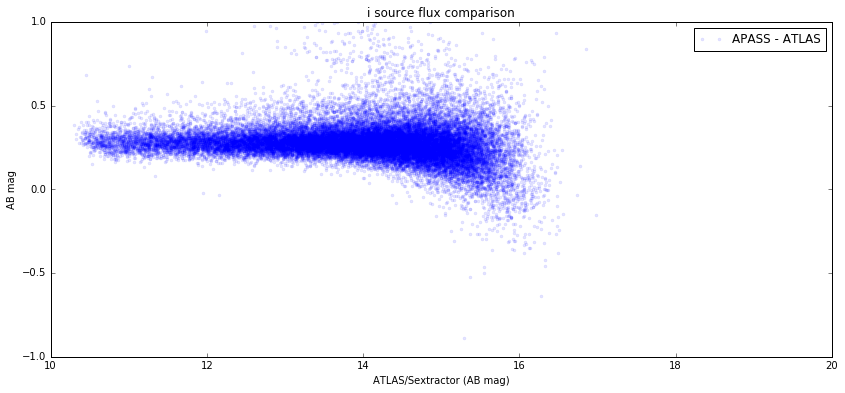

In [36]:
plt.figure(figsize=(14,6))

stys = ['b.','r.','c.']

for cati in range(len(cats)):
    plt.plot(jy2mag(secat.jy[indices_matching_srcs[cati,:]>0]),\
             jy2mag(cats[cati].jy[indices_matching_srcs[cati,indices_matching_srcs[cati,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[cati,:]>0]),stys[cati],\
             label=str(catnames[cati])+' - ATLAS',alpha=.1)

plt.xlim([10,20])
plt.ylabel('AB mag')
plt.legend()
plt.ylim([-1,1])
plt.xlabel('ATLAS/Sextractor (AB mag)')
plt.title('i source flux comparison')

#plt.savefig('skymapper_vs_dophot_vs_se_'+sefluxname+'.png',bbox_inches='tight')

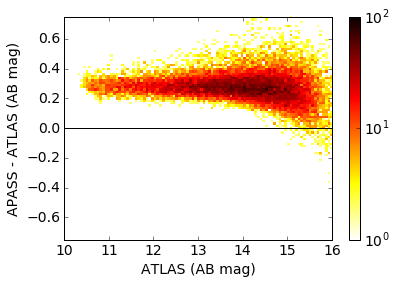

In [55]:
matplotlib.rcParams.update({'font.size': 14})
b = [np.linspace(10,16,100),np.linspace(-.75,.75,100)]
h = plt.hist2d(jy2mag(secat.jy[indices_matching_srcs[0,:]>0]),\
           jy2mag(cats[0].jy[indices_matching_srcs[0,indices_matching_srcs[0,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[0,:]>0]),\
           bins=b,\
           norm=matplotlib.colors.LogNorm(),cmap='hot_r',vmin=1,vmax=100)
plt.colorbar()
plt.plot([10,16],[0,0],'k-')
plt.xlabel('ATLAS (AB mag)')
plt.ylabel('APASS - ATLAS (AB mag)')

In [211]:
magdiff = jy2mag(cats[0].jy[indices_matching_srcs[0,indices_matching_srcs[0,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[0,:]>0])
brightenough = jy2mag(secat.jy[indices_matching_srcs[0,:]>0])<13
counts,binedges = np.histogram(magdiff[brightenough],np.linspace(.1,.5,30))
bins = .5*(binedges[1:]+binedges[:-1])

def gauss(x, *p):
    mu, sigma = p
    return np.max(counts)*np.exp(-(x-mu)**2/(2.*sigma**2))

In [212]:
coeff, var_matrix = curve_fit(gauss, bins, counts,p0=[.3,.05])

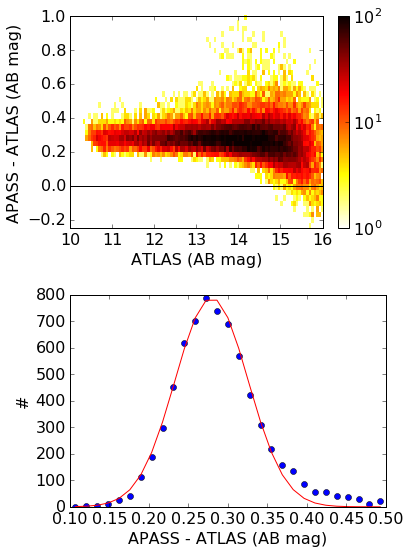

In [234]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,8))

plt.subplot(211)
b = [np.linspace(10,16,100),np.linspace(-.25,1,40)]
h = plt.hist2d(jy2mag(secat.jy[indices_matching_srcs[0,:]>0]),\
           jy2mag(cats[0].jy[indices_matching_srcs[0,indices_matching_srcs[0,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[0,:]>0]),\
           bins=b,\
           norm=matplotlib.colors.LogNorm(),cmap='hot_r',vmin=1,vmax=100)
plt.colorbar()
plt.plot([10,16],[0,0],'k-')
plt.xlabel('ATLAS (AB mag)')
plt.ylabel('APASS - ATLAS (AB mag)')

plt.subplot(212)
plt.plot(bins,counts,'o')
plt.plot(bins,gauss(bins,*coeff),'r-')
plt.xlabel('APASS - ATLAS (AB mag)')
plt.ylabel('#')

plt.tight_layout()

plt.savefig('ATLAS_vs_APASS_cal.pdf',bbox_inches='tight')

In [231]:
coeff

array([ 0.27938393,  0.04624885])

In [233]:
.279/np.sqrt(np.sum(counts))

0.0033751920770748933

In [216]:
# 0.279 \pm 0.01

In [217]:
0.04

0.04